# Planning a Coastal Survey Aircraft Tracking Mission (Functional Approach)

Implement a solution for tracking a coastal survey aircraft using an Extended Kalman Filter. The challenge is the joint assimilation of heterogeneous sensor data.

### 1. Trajectory Generation

Creates the true trajetory of the aircraft based on the initial conditions and a motion model perturbed by random acceleration.

In [90]:
import numpy as np
import matplotlib.pyplot as plt

def generate_trajectory(N, T, x0, y0, vx0, vy0, sigma_a):
    X_true = np.zeros((N, 4, 1))
    X_true[0] = np.array([[x0], [vx0], [y0], [vy0]])

    for i in range(1, N):
        x_prev, vx_prev, y_prev, vy_prev = X_true[i-1].flatten()
        ax, ay = np.random.normal(0, sigma_a, 2)
        x = x_prev + vx_prev * T + 0.5 * ax * T**2
        vx = vx_prev + ax * T
        y = y_prev + vy_prev * T + 0.5 * ay * T**2
        vy = vy_prev + ay * T
        X_true[i] = np.array([[x], [vx], [y], [vy]])

    D_true = np.sqrt(X_true[:, 0, 0]**2 + X_true[:, 2, 0]**2)
    beta_true = np.arctan2(X_true[:, 0, 0], X_true[:, 2, 0])
    
    return X_true, D_true, beta_true

In [91]:
N = 500
T = 2.0
x0, y0, vx0, vy0 = 1000.0, 1000.0, 100.0, 100.0

sigma_a_sq = 0.3**2
X_true, D_true, beta_true = generate_trajectory(N, T, x0, y0, vx0, vy0, np.sqrt(sigma_a_sq))

### 2. Measurement Generation

Simulates the data streams from the two independent stations by adding noise to the true values at the specified time steps.

In [92]:
def generate_measurements(D_true, beta_true, N, sigma_D, sigma_beta, sigma_beta_add):
    D_measured = np.full(N, np.nan)
    beta_measured = np.full(N, np.nan)
    observer_flags = np.zeros(N, dtype=int)

    for i in range(1, N, 2):
        D_measured[i] = D_true[i] + np.random.normal(0, sigma_D)
        beta_measured[i] = beta_true[i] + np.random.normal(0, sigma_beta)
        observer_flags[i] = 1

    for i in range(4, N, 2):
        beta_measured[i] = beta_true[i] + np.random.normal(0, sigma_beta_add)
        observer_flags[i] = 2

    z = np.vstack((D_measured, beta_measured)).T
    return z, observer_flags, D_measured, beta_measured

In [93]:
sigma_D = 50
sigma_beta = 0.004
sigma_beta_add = 0.001

sigma_D_sq = sigma_D**2
sigma_beta_sq = sigma_beta**2
sigma_beta_add_sq = sigma_beta_add**2

z, observer_flags, D_measured, beta_measured = generate_measurements(D_true, beta_true, N, sigma_D, sigma_beta, sigma_beta_add)

### 3. Initial Conditions for the Extended Kalman Filter

Computes the initial state guess (`X0,0`) and its uncertainty covariance (`P0,0`) based on the first two available measurements.

In [94]:
d1_m, b1_m = z[1]
d3_m, b3_m = z[3]

x1_m = d1_m * np.sin(b1_m)
y1_m = d1_m * np.cos(b1_m)
x3_m = d3_m * np.sin(b3_m)
y3_m = d3_m * np.cos(b3_m)

X0_0 = np.array([[x3_m], [(x3_m - x1_m) / (2 * T)], [y3_m], [(y3_m - y1_m) / (2 * T)]])
P0_0 = np.eye(4) * 1e4

### 4. Extended Kalman Filter Algorithm

Implements the EKF, performing the predict and filtration steps adaptively based on the incoming sensor data.

In [95]:
Phi = np.array([[1, T, 0, 0],
                [0, 1, 0, 0],
                [0, 0, 1, T],
                [0, 0, 0, 1]])
G = np.array([[0.5*T**2, 0],
              [T, 0],
              [0, 0.5*T**2],
              [0, T]])

Q = G @ G.T * sigma_a_sq

R1 = np.array([[sigma_D_sq, 0],
               [0, sigma_beta_sq]])
R2 = np.array([[sigma_beta_add_sq]])

def run_ekf(z, observer_flags, X0_0, P0_0, N):
    X_predicted, X_filtered = np.zeros((N, 4, 1)), np.zeros((N, 4, 1))
    X_filt_prev, P_filt_prev = X0_0, P0_0
    start_index = 4

    for i in range(start_index):
        X_predicted[i], X_filtered[i] = X0_0, X0_0

    for i in range(start_index, N):
        X_pred = Phi @ X_filt_prev
        P_pred = Phi @ P_filt_prev @ Phi.T + Q

        observer = observer_flags[i]
        if observer == 0: # No data
            X_filt, P_filt = X_pred, P_pred
        else:
            x_p, _, y_p, _ = X_pred.flatten()
            D_p = np.sqrt(x_p**2 + y_p**2)
            
            if observer == 1:
                H = np.array([[x_p/D_p, 0, y_p/D_p, 0],
                              [y_p/D_p**2, 0, -x_p/D_p**2, 0]])
                R = R1

                h_x = np.array([[D_p], [np.arctan2(x_p, y_p)]])
                residual = z[i].reshape(2, 1) - h_x
                residual[1, 0] = (residual[1, 0] + np.pi) % (2 * np.pi) - np.pi

            elif observer == 2:
                H = np.array([[y_p/D_p**2, 0, -x_p/D_p**2, 0]])
                R = R2
                h_x = np.array([[np.arctan2(x_p, y_p)]])
                residual = np.array([[z[i, 1] - h_x[0,0]]])
                residual[0, 0] = (residual[0, 0] + np.pi) % (2 * np.pi) - np.pi
            
            S = H @ P_pred @ H.T + R
            K = P_pred @ H.T @ np.linalg.inv(S)
            X_filt = X_pred + K @ residual
            P_filt = (np.eye(4) - K @ H) @ P_pred

        X_predicted[i], X_filtered[i] = X_pred, X_filt
        X_filt_prev, P_filt_prev = X_filt, P_filt
        
    return X_predicted, X_filtered

In [96]:
X_predicted, X_filtered = run_ekf(z, observer_flags, X0_0, P0_0, N)

### 5. Error Estimation

Calculates the true estimation errors and visualize filter performance.

In [97]:
def calculate_errors(M, N, D_true):
    sq_err_D_pred = np.zeros((M, N))
    sq_err_D_filt = np.zeros((M, N))
    sq_err_beta_pred = np.zeros((M, N))
    sq_err_beta_filt = np.zeros((M, N))

    for m in range(M):
        z, observer_flags, _, _ = generate_measurements(D_true, beta_true, N, sigma_D, sigma_beta, sigma_beta_add)

        X_pred, X_filt = run_ekf(z, observer_flags, X0_0, P0_0, N)

        D_pred = np.sqrt(X_pred[:, 0, 0]**2 + X_pred[:, 2, 0]**2)
        beta_pred = np.arctan2(X_pred[:, 0, 0], X_pred[:, 2, 0])

        D_filt = np.sqrt(X_filt[:, 0, 0]**2 + X_filt[:, 2, 0]**2)
        beta_filt = np.arctan2(X_filt[:, 0, 0], X_filt[:, 2, 0])

        err_beta_p = (beta_pred - beta_true + np.pi) % (2 * np.pi) - np.pi
        err_beta_f = (beta_filt - beta_true + np.pi) % (2 * np.pi) - np.pi

        sq_err_D_pred[m, :] = (D_pred - D_true)**2
        sq_err_D_filt[m, :] = (D_filt - D_true)**2
        sq_err_beta_pred[m, :] = err_beta_p**2
        sq_err_beta_filt[m, :] = err_beta_f**2

    rmse_D_pred = np.sqrt(np.mean(sq_err_D_pred, axis=0))
    rmse_D_filt = np.sqrt(np.mean(sq_err_D_filt, axis=0))
    rmse_beta_pred = np.sqrt(np.mean(sq_err_beta_pred, axis=0))
    rmse_beta_filt = np.sqrt(np.mean(sq_err_beta_filt, axis=0))

    return rmse_D_pred, rmse_D_filt, rmse_beta_pred, rmse_beta_filt


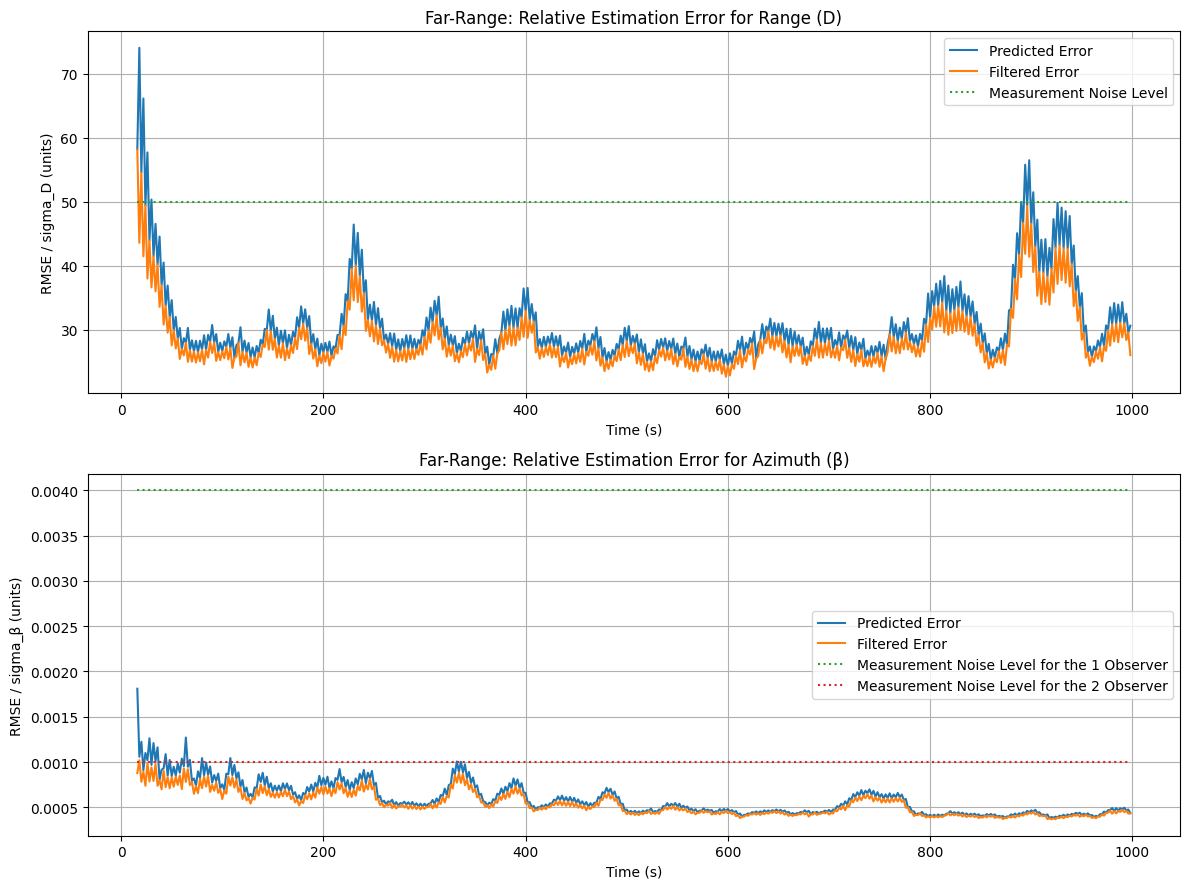

In [98]:
M = 500
rmse_D_p, rmse_D_f, rmse_b_p, rmse_b_f = calculate_errors(M, N, D_true)

timestart = 8

time = np.arange(N) * T
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9))

ax1.plot(time[timestart:], rmse_D_p[timestart:], label='Predicted Error')
ax1.plot(time[timestart:], rmse_D_f[timestart:], label='Filtered Error')
ax1.set_title('Far-Range: Relative Estimation Error for Range (D)')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('RMSE / sigma_D (units)')
ax1.plot(time[timestart:], np.full(N-timestart,sigma_D), linestyle=':', label='Measurement Noise Level')
ax1.legend()
ax1.grid()

ax2.plot(time[timestart:], rmse_b_p[timestart:], label='Predicted Error')
ax2.plot(time[timestart:], rmse_b_f[timestart:], label='Filtered Error')
ax2.set_title('Far-Range: Relative Estimation Error for Azimuth (β)')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('RMSE / sigma_β (units)')
ax2.plot(time[timestart:], np.full(N-timestart, sigma_beta), linestyle=':', label='Measurement Noise Level for the 1 Observer')
ax2.plot(time[timestart:], np.full(N-timestart, sigma_beta_add), linestyle=':', label='Measurement Noise Level for the 2 Observer')
ax2.legend()

ax2.grid()

plt.tight_layout()
plt.show()

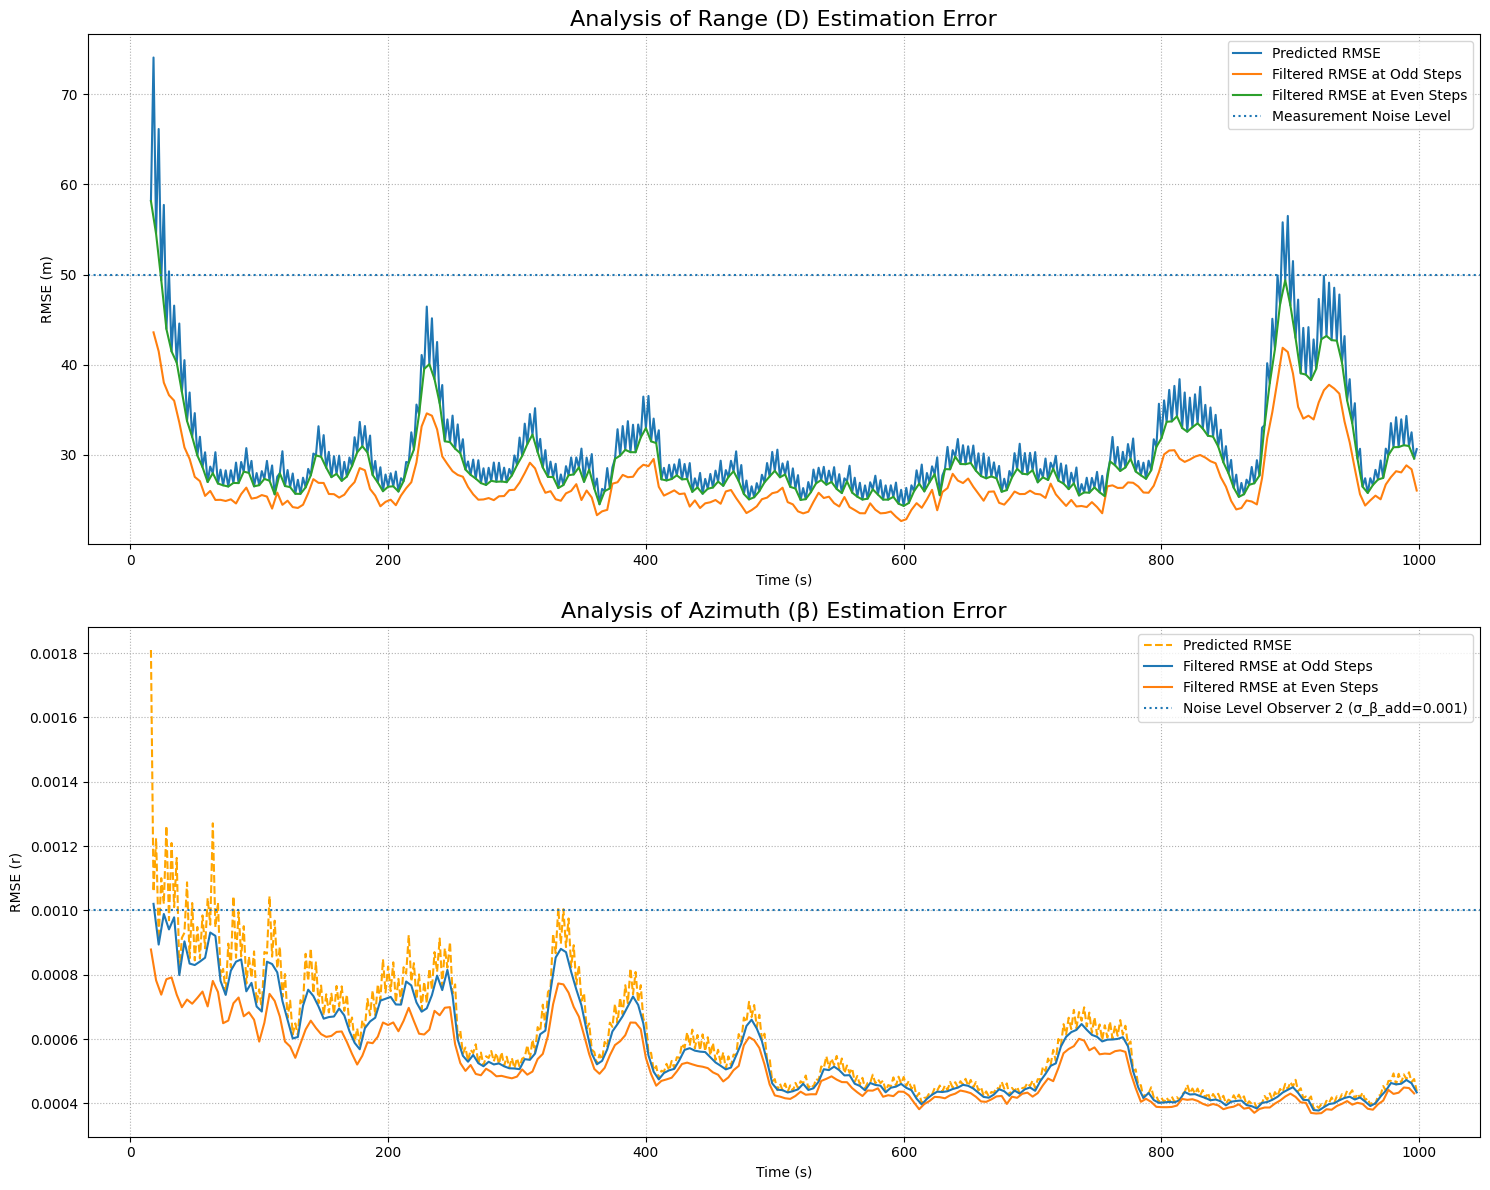

In [103]:
analysis_range = range(timestart, N)

odd_indices = [i for i in analysis_range if i % 2 != 0]
even_indices = [i for i in analysis_range if i % 2 == 0]

time_odd = time[odd_indices]
time_even = time[even_indices]

rmse_D_odd = rmse_D_f[odd_indices]
rmse_D_even = rmse_D_f[even_indices]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
ax1.plot(time[timestart:], rmse_D_p[timestart:], label='Predicted RMSE')
ax1.plot(time_odd, rmse_D_odd, label='Filtered RMSE at Odd Steps')
ax1.plot(time_even, rmse_D_even, label='Filtered RMSE at Even Steps')
ax1.set_title('Analysis of Range (D) Estimation Error', fontsize=16)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('RMSE (m)')
ax1.axhline(y=sigma_D, linestyle=':', label=f'Measurement Noise Level')
ax1.legend()
ax1.grid(True, linestyle=':')

rmse_beta_odd = rmse_b_f[odd_indices]
rmse_beta_even = rmse_b_f[even_indices]

ax2.plot(time[timestart:], rmse_b_p[timestart:], color='orange', linestyle='--', label='Predicted RMSE')

ax2.plot(time_odd, rmse_beta_odd, label='Filtered RMSE at Odd Steps')
ax2.plot(time_even, rmse_beta_even, label='Filtered RMSE at Even Steps')
ax2.set_title('Analysis of Azimuth (β) Estimation Error', fontsize=16)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('RMSE (r)')
# ax2.axhline(y=sigma_beta, linestyle=':', label=f'Noise Level Observer 1 (σ_β={sigma_beta})')
ax2.axhline(y=sigma_beta_add, linestyle=':', label=f'Noise Level Observer 2 (σ_β_add={sigma_beta_add})')
ax2.legend()
ax2.grid(True, linestyle=':')

plt.tight_layout()
plt.show()


## Learning Log

1. Two independent sensors can be combined to create a robust and accurate tracking system. By jointly assimilating sensors data, the EKF produced a great estimation.

2. Real-world data is rarely clean, uniform, or perfectly timed. We simulated two data streams with different characteristics and different update schedules. Implementing the logic in the EKF's filtration step to dynamically change the measurement matrix `H` and noise covariance `R` allows to build a robust model.

3. The error plots are a powerful diagnostic for understanding the filter's internal behavior.

The joint assimilation strategy effectively leverages the strengths of each sensor to overcome their individual weaknesses, resulting in a continuous, high-accuracy trajectory reconstruction.